In [18]:
import numpy as np
import threading
import queue
import time
import matplotlib.pyplot as plt
from datetime import date

In [19]:
def simple_NMF(a, k, i):
    m, n = np.shape(a)
    w = np.random.rand(m, k)
    h = np.random.rand(k, n)
    for _ in range(i):
        w = w * (a @ h.T) / (w @ h @ h.T)
        h = h * (w.T @ a) / (w.T @ w @ h)
    return w @ h

simple_NMF(np.identity(8)+1, 8, 1000)

array([[2., 1., 1., 1., 1., 1., 1., 1.],
       [1., 2., 1., 1., 1., 1., 1., 1.],
       [1., 1., 2., 1., 1., 1., 1., 1.],
       [1., 1., 1., 2., 1., 1., 1., 1.],
       [1., 1., 1., 1., 2., 1., 1., 1.],
       [1., 1., 1., 1., 1., 2., 1., 1.],
       [1., 1., 1., 1., 1., 1., 2., 1.],
       [1., 1., 1., 1., 1., 1., 1., 2.]])

In [20]:
def thread_function_w(a, w, h, q, i):
    q.put((i, w * (a @ h.T) / (w @ h @ h.T)))

def thread_function_h(a, w, h, q, i):
    q.put((i, h * (w.T @ a) / (w.T @ w @ h)))

def naive_parallel_NMF(a, k, p, numIter):
    m, n = np.shape(a)
    if m % p > 0:
        raise TypeError('Input first dimension not divisible by number of threads')
    if n % p > 0:
        raise TypeError('Input second dimension not divisible by number of threads')
    w = np.random.rand(m, k)
    h = np.random.rand(k, n)
    a_pieces_1 = np.split(a, p, 0) # cut a into p pieces of shape m/p x n
    assert np.shape(a_pieces_1[0]) == (int(m/p), n)
    a_pieces_2 = np.split(a, p, 1) # cut a into p pieces of shape m x n/p
    assert np.shape(a_pieces_2[0]) == (m, int(n/p))
    
    for _ in range(numIter):
        w_pieces = np.split(w, p, 0) # cut w into p pieces of shape m/p x n
        assert np.shape(w_pieces[0]) == (int(m/p), k)
        w_threads = []
        w_queue = queue.Queue()
        for j in range(p): # split into p threads to calculate updates for each piece
            newThread = threading.Thread(target = thread_function_w, args = (a_pieces_1[j], w_pieces[j], h, w_queue, j))
            newThread.start()
            w_threads.append(newThread)
        for thread in w_threads: # wait for all threads to complete
            thread.join()
        while not w_queue.empty(): # reconstitute and update w
            i, val = w_queue.get()
            w_pieces[i] = val
        w = np.concatenate(w_pieces, 0)

        h_pieces = np.split(h, p, 1) # cut h into p pieces of shape m x n/p
        assert np.shape(h_pieces[0]) == (k, int(n/p))
        h_threads = []
        h_queue = queue.Queue()
        for j in range(p): # split into p threads to calculate updates for each piece
            newThread = threading.Thread(target = thread_function_h, args = (a_pieces_2[j], w, h_pieces[j], h_queue, j))
            newThread.start()
            h_threads.append(newThread)
        for thread in h_threads: # wait for all threads to complete
            thread.join()
        while not h_queue.empty(): # reconstitute and update h
            i, val = h_queue.get()
            h_pieces[i] = val
        h = np.concatenate(h_pieces, 1)
    return w @ h
    
naive_parallel_NMF(np.identity(8)+1, 8, 4, 1000)

array([[2., 1., 1., 1., 1., 1., 1., 1.],
       [1., 2., 1., 1., 1., 1., 1., 1.],
       [1., 1., 2., 1., 1., 1., 1., 1.],
       [1., 1., 1., 2., 1., 1., 1., 1.],
       [1., 1., 1., 1., 2., 1., 1., 1.],
       [1., 1., 1., 1., 1., 2., 1., 1.],
       [1., 1., 1., 1., 1., 1., 2., 1.],
       [1., 1., 1., 1., 1., 1., 1., 2.]])

In [21]:
def vertical_thread_function_u(h, q):
    q.put(h @ h.T)

def vertical_thread_function_v(a, h, q, i):
    q.put((i, a @ h.T))

def vertical_thread_function_w(w, u, y, q, i):
    q.put((i, w * y / (w @ u)))

def vertical_thread_function_x(w, q):
    q.put(w.T @ w)

def vertical_thread_function_y(a, w, q, i):
    q.put((i, w.T @ a))

def vertical_thread_function_h(h, x, y, q, i):
    q.put((i, h * y / (x @ h)))

def vertical_HPC_NMF(a, k, p_row, p_col, numIter):
    m, n = np.shape(a)
    if m % (p_row*p_col) > 0:
        raise TypeError('Input first dimension not divisible by number of threads')
    if n % (p_row*p_col) > 0:
        raise TypeError('Input second dimension not divisible by number of threads')
    w = np.random.rand(m, k)
    h = np.random.rand(k, n)

    a_pieces = [np.split(x, p_col, 1) for x in np.split(a, p_row, 0)] # cut a into p_row x p_col pieces of shape m/p_row x n/p_col
    assert np.shape(a_pieces[0][0]) == (int(m/p_row), int(n/p_col))

    for _ in range(numIter):
        u = np.zeros((k, k))
        h_pieces_u = np.split(h, p_row*p_col, 1) # cut h into p_row*p_col pieces of shape k x n/(p_row*p_col)
        assert np.shape(h_pieces_u[0]) == (k, int(n/(p_row*p_col)))
        threads_u = []
        queue_u = queue.Queue()
        for i in range(p_row*p_col): # split into p_row*p_col threads to calculate u for each piece
            newThread = threading.Thread(target = vertical_thread_function_u, args = (h_pieces_u[i], queue_u))
            newThread.start()
            threads_u.append(newThread)
        for thread in threads_u: # wait for all threads to complete
            thread.join()
        while not queue_u.empty(): # sum up u
            u += queue_u.get()
        assert np.all(np.isclose(u, h @ h.T))       

        v = np.zeros((m, k))
        v_pieces = np.split(v, p_row, 0) # cut v into p_row pieces of shape m/p_row x k
        assert np.shape(v_pieces[0]) == (int(m/p_row), k)
        h_pieces_v = np.split(h, p_col, 1) # cut h into p_col pieces of shape k x n/p_col
        assert np.shape(h_pieces_v[0]) == (k, int(n/p_col))
        threads_v = []
        queue_v = queue.Queue()
        for i in range(p_row*p_col): # split into p_row*p_col threads to calculate updates for each piece
            newThread = threading.Thread(target = vertical_thread_function_v, args = (a_pieces[int(i/p_col)][i%p_col], h_pieces_v[i%p_col], queue_v, i))
            newThread.start()
            threads_v.append(newThread)
        for thread in threads_v: # wait for all threads to complete
            thread.join()
        while not queue_v.empty(): # sum up v
            i, val = queue_v.get()
            v_pieces[int(i/p_col)] += val
        v = np.concatenate(v_pieces, 0)
        assert np.all(np.isclose(v, a @ h.T))
        
        w_pieces = np.split(w, p_row*p_col, 0) # cut w into p_row x p_col pieces of shape m/(p_row*p_col) x k
        assert np.shape(w_pieces[0]) == (m/(p_row*p_col), k)
        v_pieces_w = np.split(v, p_row*p_col, 0) # cut v into p_row x p_col pieces of shape m/(p_row*p_col) x k
        assert np.shape(v_pieces_w[0]) == (m/(p_row*p_col), k)
        threads_w = []
        queue_w = queue.Queue()
        for i in range(p_row*p_col): # split into p_row*p_col threads to calculate updates for each piece
            newThread = threading.Thread(target = vertical_thread_function_w, args = (w_pieces[i], u, v_pieces_w[i], queue_w, i))
            newThread.start()
            threads_w.append(newThread)
        for thread in threads_w: # wait for all threads to complete
            thread.join()
        while not queue_w.empty(): # sum up u
            i, val = queue_w.get()
            w_pieces[i] = val
        w = np.concatenate(w_pieces, 0)
        
        x = np.zeros((k, k))
        w_pieces_x = np.split(w, p_row*p_col, 0) # cut x into p_row*p_col pieces of shape n/(p_row*p_col) x k
        assert np.shape(w_pieces_x[0]) == (int(n/(p_row*p_col)), k)
        threads_x = []
        queue_x = queue.Queue()
        for i in range(p_row*p_col): # split into p_row*p_col threads to calculate u for each piece
            newThread = threading.Thread(target = vertical_thread_function_x, args = (w_pieces_x[i], queue_x))
            newThread.start()
            threads_x.append(newThread)
        for thread in threads_x: # wait for all threads to complete
            thread.join()
        while not queue_x.empty(): # sum up x
            x += queue_x.get()
        assert np.all(np.isclose(x, w.T @ w))

        y = np.zeros((k, n))
        y_pieces = np.split(y, p_col, 1) # cut y into p_col pieces of shape k x n/p_col
        assert np.shape(y_pieces[0]) == (k, int(n/p_col))
        w_pieces_y = np.split(w, p_row, 0) # cut w into p_row pieces of shape m/p_row x k
        assert np.shape(w_pieces_y[0]) == (int(m/p_row), k)
        threads_y = []
        queue_y = queue.Queue()
        for i in range(p_row*p_col): # split into p_row*p_col threads to calculate updates for each piece
            newThread = threading.Thread(target = vertical_thread_function_y, args = (a_pieces[i%p_row][int(i/p_row)], w_pieces_y[i%p_row], queue_y, i))
            newThread.start()
            threads_y.append(newThread)
        for thread in threads_y: # wait for all threads to complete
            thread.join()
        while not queue_y.empty(): # sum up y
            i, val = queue_y.get()
            y_pieces[int(i/p_row)] += val
        y = np.concatenate(y_pieces, 1)
        assert np.all(np.isclose(y, w.T @ a))

        h_pieces = np.split(h, p_row*p_col, 1) # cut h into p_row x p_col pieces of shape m/(p_row*p_col) x k
        assert np.shape(h_pieces[0]) == (k, int(n/(p_row*p_col)))
        y_pieces_h = np.split(y, p_row*p_col, 1) # cut y into p_row x p_col pieces of shape m/(p_row*p_col) x k
        assert np.shape(y_pieces_h[0]) == (k, int(n/(p_row*p_col)))
        threads_h = []
        queue_h = queue.Queue()
        for i in range(p_row*p_col): # split into p_row*p_col threads to calculate updates for each piece
            newThread = threading.Thread(target = vertical_thread_function_h, args = (h_pieces[i], x, y_pieces_h[i], queue_h, i))
            newThread.start()
            threads_h.append(newThread)
        for thread in threads_h: # wait for all threads to complete
            thread.join()
        while not queue_h.empty(): # sum up u
            i, val = queue_h.get()
            h_pieces[i] = val
        h = np.concatenate(h_pieces, 1)        
    return w @ h

vertical_HPC_NMF(np.identity(8)+1, 8, 4, 2, 1000)

array([[2., 1., 1., 1., 1., 1., 1., 1.],
       [1., 2., 1., 1., 1., 1., 1., 1.],
       [1., 1., 2., 1., 1., 1., 1., 1.],
       [1., 1., 1., 2., 1., 1., 1., 1.],
       [1., 1., 1., 1., 2., 1., 1., 1.],
       [1., 1., 1., 1., 1., 2., 1., 1.],
       [1., 1., 1., 1., 1., 1., 2., 1.],
       [1., 1., 1., 1., 1., 1., 1., 2.]])

In [33]:
lock = threading.Lock()

def hpc_thread_function_w(a, w, h, crossQueues, outQueue, i):
    my_u = h @ h.T # calculate my piece of u
    u = h @ h.T # keep a running sum (not a reference to my_u!!)
    status = [0 for _ in crossQueues] # 0 means nothing done yet
    while sum(status) < 2*len(crossQueues): # 2 means done
        for j, q in enumerate(crossQueues):
            if status[j] == 0 and q.empty():
                q.put((i, my_u))
                status[j] = 1 # 1 means in write-first mode
            elif status[j] == 0 and not q.empty():
                other_i, other_u = q.get()
                u += other_u
                lock.acquire()
                q.put((i, my_u))
                q.put(None) # mark that content has been read and re-written by filling queue to 2
                lock.release()
                status[j] = 2 # 2 means done
            elif status[j] == 1 and q.full(): # see that content has been read and re-written
                other_i, other_u = q.get()
                u += other_u
                q.get() # clear the cross-queue
                status[j] = 2 # 2 means done
    outQueue.put(u)

def hpc_thread_function_h(a, w, h, q, i):
    return 0

def HPC_NMF(a, k, p_row, p_col, numIter):
    m, n = np.shape(a)
    if m % (p_row*p_col) > 0:
        raise TypeError('Input first dimension not divisible by number of threads')
    if n % (p_row*p_col) > 0:
        raise TypeError('Input second dimension not divisible by number of threads')
    w = np.random.rand(m, k)
    h = np.random.rand(k, n)

    a_pieces = [np.split(x, p_col, 1) for x in np.split(a, p_row, 0)] # cut a into p_row x p_col pieces of shape m/p_row x n/p_col
    assert np.shape(a_pieces[0][0]) == (int(m/p_row), int(n/p_col))

    for _ in range(numIter):
        u = np.zeros((k, k))
        h_pieces = np.split(h, p_row*p_col, 1) # cut h into p_row*p_col pieces of shape k x n/(p_row*p_col)
        assert np.shape(h_pieces[0]) == (k, int(n/(p_row*p_col)))

        threads_w = []
        cross_queues_w = []
        out_queue_w = queue.Queue(maxsize=p_row*p_col)
        for i in range(p_row*p_col):
            for j in range(i+1, p_row*p_col):
                cross_queues_w.append((i, j, queue.Queue(maxsize=2)))
        for i in range(p_row*p_col): # split into p threads to calculate updates for each piece
            newThread = threading.Thread(target = hpc_thread_function_w, args = 
                (a_pieces[i%p_row][int(i/p_row)],
                 w,
                 h_pieces[i],
                 [q for j, jj, q in cross_queues_w if i == j or i == jj],
                 out_queue_w,
                 i))
            newThread.start()
            threads_w.append(newThread)
        for thread in threads_w: # wait for all threads to complete
            thread.join()
        while not out_queue_w.empty(): # reconstitute and update w
            u = out_queue_w.get()
            assert np.all(np.isclose(u, h @ h.T))
    return

HPC_NMF(np.identity(8)+1, 4, 2, 2, 1)

In [ ]:
def timingFunc(func, args, iterations):
    times = []
    for _ in range(iterations):
        start = time.perf_counter()
        func(*args)
        times.append(time.perf_counter()-start)
    return np.mean(times)

k = 4
p0 = 2
p1 = 2
iter = 100
points = 10
sizes = [p0*p1*i for i in range(1, 10)]
simple = [timingFunc(simple_NMF, (np.identity(i)+1, k, iter), points) for i in sizes]
naive = [timingFunc(naive_parallel_NMF, (np.identity(i)+1, k, p0*p1, iter), points) for i in sizes]
vertical = [timingFunc(vertical_HPC_NMF, (np.identity(i)+1, k, p0, p1, iter), points) for i in sizes]

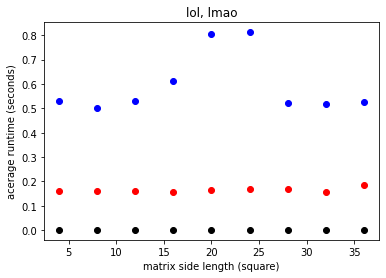

In [ ]:
plt.plot(sizes, simple, 'ko')
plt.plot(sizes, naive, 'ro')
plt.plot(sizes, vertical, 'bo')
plt.title('lol, lmao')
plt.xlabel('matrix side length (square)')
plt.ylabel('acerage runtime (seconds)')
plt.show()